In [48]:
# Run this cell once to install resampy if not already installed
# !pip install resampy torcheval # torcheval for simplified metrics (optional)

import numpy as np
import pandas as pd
import os
import librosa
import librosa.display
import resampy # Though librosa uses it, explicit import is good practice
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

print("Imports successful!")

Imports successful!


In [49]:
# --- Configuration ---
# For Mel Spectrograms
N_MELS = 128  # Number of Mel bands (this will be our "num_rows")
FMAX = 8000   # Maximum frequency for Mel bands
# TIME_FRAMES_MAX_LEN is for the time axis (columns), remains the same or adjust as needed
TIME_FRAMES_MAX_LEN = 174 # Max length for the time axis of the spectrogram

# Data processing limits (set to None to process all files, otherwise set a number like 500 for testing)
num_rows_to_process = 500
# num_rows_to_process = None


# Paths
fulldatasetpath = "/kaggle/input/urban-8k-dataset/UrbanSound8K/audio"
metadata_path = '/kaggle/input/urban-8k-dataset/UrbanSound8K/metadata/UrbanSound8K.csv'
SAVED_MODEL_DIR = 'saved_models_pytorch_melspec' # New directory for this version
os.makedirs(SAVED_MODEL_DIR, exist_ok=True)

print("Configuration set.")
print(f"Number of Mel bands (N_MELS): {N_MELS}")
print(f"Max time frames (TIME_FRAMES_MAX_LEN): {TIME_FRAMES_MAX_LEN}")
print(f"Number of files to process: {'All' if num_rows_to_process is None else num_rows_to_process}")

Configuration set.
Number of Mel bands (N_MELS): 128
Max time frames (TIME_FRAMES_MAX_LEN): 174
Number of files to process: 500


In [50]:
# --- Feature Extraction (Now for Mel Spectrograms) ---
def extract_features_mel_spectrogram(file_name, n_mels=N_MELS, fmax=FMAX, max_len=TIME_FRAMES_MAX_LEN, return_audio_sr=False):
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
        
        mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=n_mels, fmax=fmax)
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

        pad_width = max_len - log_mel_spectrogram.shape[1]
        if pad_width < 0:
            log_mel_spectrogram = log_mel_spectrogram[:, :max_len]
        else:
            log_mel_spectrogram = np.pad(log_mel_spectrogram, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
        if return_audio_sr:
            return log_mel_spectrogram, audio, sample_rate
        else:
            return log_mel_spectrogram
            
    except Exception as e:
        # print(f"Error encountered while parsing file for Mel Spectrogram: {file_name}. Error: {e}") # Less verbose
        if return_audio_sr:
            return None, None, None
        else:
            return None

# --- Function to plot Spectrogram (Mel) ---
def plot_mel_spectrogram(file_path, class_label="Unknown"):
    # print(f"\nPlotting Mel Spectrogram for: {os.path.basename(file_path)} (Class: {class_label})") # Less verbose during bulk plotting
    try:
        log_mel_spec, audio, sr = extract_features_mel_spectrogram(file_path, return_audio_sr=True)
        
        if log_mel_spec is None:
            # print("Could not extract Mel Spectrogram for plotting.") # Less verbose
            return

        fig, ax = plt.subplots(figsize=(10, 4))
        img = librosa.display.specshow(log_mel_spec, sr=sr, x_axis='time', y_axis='mel', ax=ax, fmax=FMAX)
        ax.set_title(f'Mel Spectrogram (dB) - {class_label} ({os.path.basename(file_path)})')
        fig.colorbar(img, ax=ax, format='%+2.0f dB')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error processing and plotting Mel Spectrogram for {file_path}: {e}")

print("Helper functions defined.")

Helper functions defined.


In [61]:
metadata_df_global = pd.read_csv(metadata_path)
print("Metadata columns:", metadata_df_global.columns)
print(f"Total rows in metadata: {len(metadata_df_global)}")
print(f"Number of unique classes: {metadata_df_global['class'].nunique()}")

print("\nClass-wise distribution of samples in the full metadata:")
print(metadata_df_global['class'].value_counts()) # Added this line


features_list = []
print(f"\nStarting Mel Spectrogram extraction for model training...")
processed_count = 0
for index, row in metadata_df_global.iterrows():
    if num_rows_to_process is not None and index >= num_rows_to_process:
        break
    file_name = os.path.join(os.path.abspath(fulldatasetpath), 'fold'+str(row["fold"])+'/', str(row["slice_file_name"]))
    
    data = extract_features_mel_spectrogram(file_name) # return_audio_sr is False by default
    if data is not None:
        features_list.append([data, row["class"]])
        processed_count += 1

    if (index + 1) % 100 == 0:
        print(f"Processed {index + 1} metadata rows. Extracted features for {processed_count} files.")

featuresdf = pd.DataFrame(features_list, columns=['feature', 'class_label'])
print(f'\nFinished Mel Spectrogram extraction from {len(featuresdf)} files for model training.')
print(f"Shape of a sample feature: {featuresdf.feature.iloc[0].shape if len(featuresdf) > 0 else 'N/A'}")

Metadata columns: Index(['slice_file_name', 'fsID', 'start', 'end', 'salience', 'fold',
       'classID', 'class'],
      dtype='object')
Total rows in metadata: 8732
Number of unique classes: 10

Class-wise distribution of samples in the full metadata:
class
dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
jackhammer          1000
engine_idling       1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: count, dtype: int64

Starting Mel Spectrogram extraction for model training...
Processed 100 metadata rows. Extracted features for 100 files.
Processed 200 metadata rows. Extracted features for 200 files.
Processed 300 metadata rows. Extracted features for 300 files.
Processed 400 metadata rows. Extracted features for 400 files.
Processed 500 metadata rows. Extracted features for 500 files.

Finished Mel Spectrogram extraction from 500 files for model training.
Shape of a sample 

In [63]:
featuresdf

,feature,class_label
0,"[[-73.46988, -67.18866, -66.366035, -74.36304,...",dog_bark
1,"[[-14.308695, -8.309402, -12.19869, -14.643091...",children_playing
2,"[[-23.660896, -15.784438, -9.464203, -10.68742...",children_playing
3,"[[-17.288895, -17.055046, -21.717485, -20.9035...",children_playing
4,"[[-8.943642, -5.962576, -8.108492, -9.179434, ...",children_playing
...,...,...
495,"[[-34.313023, -28.381786, -30.656897, -31.6789...",siren
496,"[[-31.860697, -7.470106, -3.9801464, -4.620146...",gun_shot
497,"[[-37.046227, -39.61805, -41.19423, -40.625397...",car_horn
498,"[[-39.756462, -40.747684, -41.32563, -36.29789...",car_horn


In [52]:
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

le = LabelEncoder()
y_encoded = le.fit_transform(y)
num_labels = len(le.classes_)
print(f"Number of unique classes: {num_labels}")
print(f"Classes: {le.classes_}")


x_train_raw, x_test_raw, y_train_raw, y_test_raw = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"x_train_raw shape: {x_train_raw.shape}, y_train_raw shape: {y_train_raw.shape}")
print(f"x_test_raw shape: {x_test_raw.shape}, y_test_raw shape: {y_test_raw.shape}")


# PyTorch Dataset
class UrbanSoundDataset(Dataset):
    def __init__(self, features, labels, num_mel_bands, num_time_frames, num_channels=1):
        self.features = features
        self.labels = labels
        self.num_mel_bands = num_mel_bands
        self.num_time_frames = num_time_frames
        self.num_channels = num_channels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = self.features[idx].reshape(self.num_channels, self.num_mel_bands, self.num_time_frames)
        label = self.labels[idx]
        return torch.tensor(feature, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

MODEL_INPUT_NUM_ROWS = N_MELS
MODEL_INPUT_NUM_COLUMNS = TIME_FRAMES_MAX_LEN
num_channels = 1

train_dataset = UrbanSoundDataset(x_train_raw, y_train_raw, MODEL_INPUT_NUM_ROWS, MODEL_INPUT_NUM_COLUMNS, num_channels)
test_dataset = UrbanSoundDataset(x_test_raw, y_test_raw, MODEL_INPUT_NUM_ROWS, MODEL_INPUT_NUM_COLUMNS, num_channels)

# PyTorch DataLoader
num_batch_size = 32 # Adjust based on GPU memory
train_loader = DataLoader(train_dataset, batch_size=num_batch_size, shuffle=True, num_workers=2, pin_memory=True) # num_workers > 0 for faster loading
test_loader = DataLoader(test_dataset, batch_size=num_batch_size, shuffle=False, num_workers=2, pin_memory=True)

print(f"\nTrain dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
# Verify a batch
# for xb, yb in train_loader:
#     print("Shape of a training batch (features):", xb.shape) # Should be (batch_size, num_channels, N_MELS, TIME_FRAMES_MAX_LEN)
#     print("Shape of a training batch (labels):", yb.shape)
#     break

Number of unique classes: 10
Classes: ['air_conditioner' 'car_horn' 'children_playing' 'dog_bark' 'drilling'
 'engine_idling' 'gun_shot' 'jackhammer' 'siren' 'street_music']
x_train_raw shape: (400, 128, 174), y_train_raw shape: (400,)
x_test_raw shape: (100, 128, 174), y_test_raw shape: (100,)

Train dataset size: 400
Test dataset size: 100


In [72]:
x_train_raw.shape, x_test_raw.shape, y_train_raw.shape, y_test_raw.shape

((400, 128, 174), (100, 128, 174), (400,), (100,))

In [74]:
x_train_raw

array([[[-34.450024 , -24.995039 , -25.633734 , ..., -25.05038  ,
         -28.312077 ,   0.       ],
        [-30.0111   , -20.6666   , -20.050575 , ..., -19.576422 ,
         -23.32809  ,   0.       ],
        [-30.969566 , -23.756367 , -22.499771 , ..., -23.97598  ,
         -23.937681 ,   0.       ],
        ...,
        [-34.242645 , -24.507921 , -26.186016 , ..., -26.628395 ,
         -38.582043 ,   0.       ],
        [-34.941235 , -25.590605 , -26.90665  , ..., -29.673965 ,
         -42.244884 ,   0.       ],
        [-32.965427 , -21.906227 , -23.60229  , ..., -34.7413   ,
         -47.661045 ,   0.       ]],

       [[-21.75903  , -23.669506 , -22.225166 , ..., -16.546017 ,
         -19.303312 ,   0.       ],
        [-18.314924 , -20.95169  , -21.656559 , ..., -13.926831 ,
         -14.793509 ,   0.       ],
        [-16.395998 , -17.66475  , -18.598007 , ..., -17.207949 ,
         -14.868734 ,   0.       ],
        ...,
        [-57.74208  , -60.324787 , -59.925014 , ..., -

In [53]:
class AudioCNN(nn.Module):
    def __init__(self, num_labels, num_input_rows, num_input_cols, num_channels):
        super(AudioCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=16, kernel_size=3, padding='same')
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(16) # Added BatchNorm
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.drop1 = nn.Dropout(0.25) # Slightly increased dropout

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding='same')
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.drop2 = nn.Dropout(0.25)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same')
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.drop3 = nn.Dropout(0.3) # Increased dropout

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding='same')
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(128)
        self.pool4 = nn.MaxPool2d(kernel_size=2)
        self.drop4 = nn.Dropout(0.3)
        
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_labels)

    def forward(self, x):
        x = self.drop1(self.pool1(self.bn1(self.relu1(self.conv1(x)))))
        x = self.drop2(self.pool2(self.bn2(self.relu2(self.conv2(x)))))
        x = self.drop3(self.pool3(self.bn3(self.relu3(self.conv3(x)))))
        x = self.drop4(self.pool4(self.bn4(self.relu4(self.conv4(x)))))
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

print("AudioCNN model defined.")
# A small update to the CNN: Added BatchNorm layers, which often help with training stability and speed,
# and slightly increased dropout for potentially better regularization with richer Mel spectrogram input.

AudioCNN model defined.


In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = AudioCNN(num_labels=num_labels, 
                 num_input_rows=MODEL_INPUT_NUM_ROWS, 
                 num_input_cols=MODEL_INPUT_NUM_COLUMNS, 
                 num_channels=num_channels).to(device)
print("\nModel Architecture:")
print(model)

# Optional: Use torchsummary for a Keras-like summary
# try:
#     from torchsummary import summary
#     summary(model, input_size=(num_channels, MODEL_INPUT_NUM_ROWS, MODEL_INPUT_NUM_COLUMNS))
# except ImportError:
#     print("\n torchsummary not found. Skipping model summary.")


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # You might want to try AdamW or different LRs
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5, verbose=True) # Optional LR scheduler

# Evaluation Function
def evaluate_model(data_loader, model, criterion, device):
    model.eval()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    avg_loss = total_loss / total_samples if total_samples > 0 else 0
    accuracy = correct_predictions / total_samples if total_samples > 0 else 0
    return avg_loss, accuracy, all_labels, all_preds

print("\nModel, criterion, optimizer, and evaluation function initialized.")

Using device: cuda

Model Architecture:
AudioCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (relu1): ReLU()
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.25, inplace=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (relu2): ReLU()
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (relu3): ReLU()
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop3): Dropout(p=0.3, inplace=False)
  (conv4): Conv2d(64, 

In [55]:
num_epochs = 50  # Start with a moderate number, e.g., 50-100. Adjust based on results.
best_val_accuracy = 0.0
model_save_path = os.path.join(SAVED_MODEL_DIR, 'weights.best.melspec_cnn.pth')

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

start_time = datetime.now()
print(f"\nStarting training with Mel Spectrograms for {num_epochs} epochs...")

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    epoch_train_loss = running_loss / total_train if total_train > 0 else 0
    epoch_train_acc = correct_train / total_train if total_train > 0 else 0
    
    # Validation
    val_loss, val_acc, _, _ = evaluate_model(test_loader, model, criterion, device)
    
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc*100:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")
    
    # if scheduler: # Optional: Step the scheduler
    #     scheduler.step(val_loss)

    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        torch.save(model.state_dict(), model_save_path)
        print(f"Validation accuracy improved to {best_val_accuracy*100:.2f}%. Model saved to {model_save_path}")

duration = datetime.now() - start_time
print(f"\nTraining completed in time: {duration}")
print(f"Best Validation Accuracy: {best_val_accuracy*100:.2f}%")


Starting training with Mel Spectrograms for 50 epochs...
Epoch [1/50], Train Loss: 1.5648, Train Acc: 48.75%, Val Loss: 1.6673, Val Acc: 51.00%
Validation accuracy improved to 51.00%. Model saved to saved_models_pytorch_melspec/weights.best.melspec_cnn.pth
Epoch [2/50], Train Loss: 1.0777, Train Acc: 64.25%, Val Loss: 1.4741, Val Acc: 49.00%
Epoch [3/50], Train Loss: 0.8925, Train Acc: 74.25%, Val Loss: 1.4720, Val Acc: 53.00%
Validation accuracy improved to 53.00%. Model saved to saved_models_pytorch_melspec/weights.best.melspec_cnn.pth
Epoch [4/50], Train Loss: 0.7663, Train Acc: 80.75%, Val Loss: 1.6359, Val Acc: 46.00%
Epoch [5/50], Train Loss: 0.6230, Train Acc: 82.75%, Val Loss: 1.1709, Val Acc: 60.00%
Validation accuracy improved to 60.00%. Model saved to saved_models_pytorch_melspec/weights.best.melspec_cnn.pth
Epoch [6/50], Train Loss: 0.5522, Train Acc: 83.00%, Val Loss: 1.3999, Val Acc: 63.00%
Validation accuracy improved to 63.00%. Model saved to saved_models_pytorch_melsp

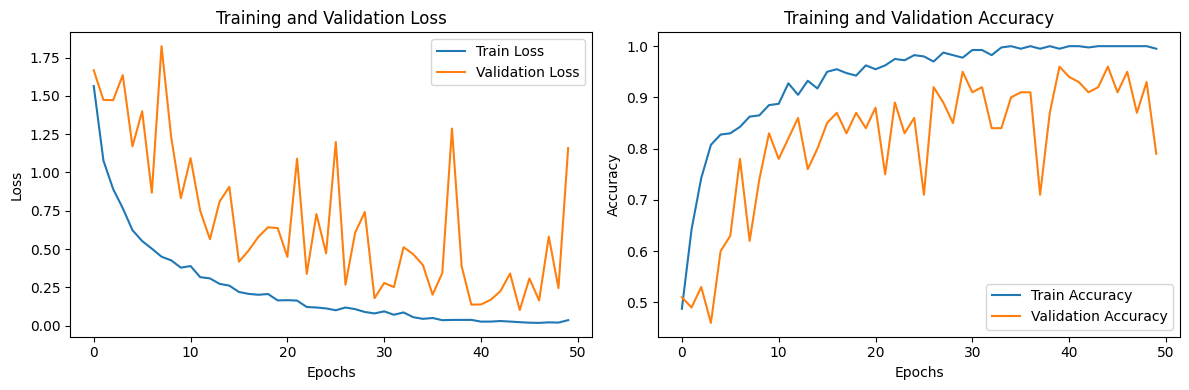

In [56]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


Loading best model from saved_models_pytorch_melspec/weights.best.melspec_cnn.pth for final evaluation...
Final Training Loss: 0.1469, Final Training Accuracy: 95.75%
Final Test Loss: 0.1369, Final Test Accuracy: 96.00%


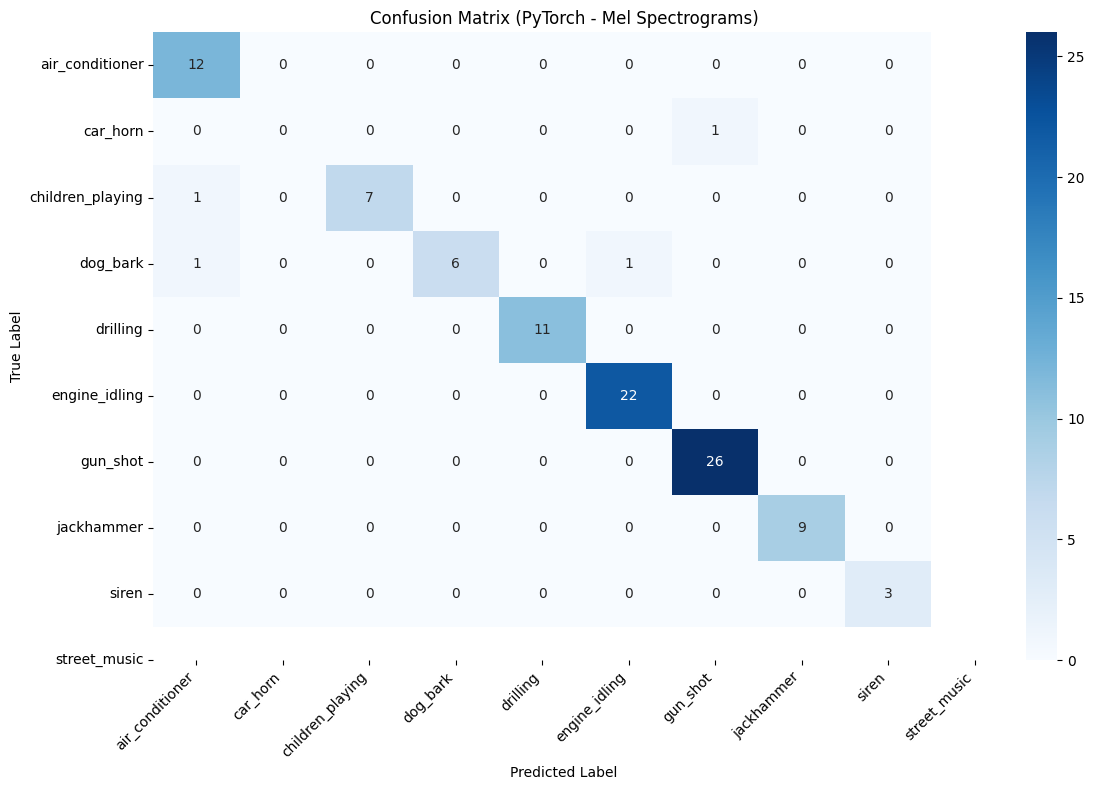

In [57]:
if os.path.exists(model_save_path):
    print(f"\nLoading best model from {model_save_path} for final evaluation...")
    model.load_state_dict(torch.load(model_save_path))
else:
    print(f"\nNo saved model found at {model_save_path}. Evaluating with the current model state (last epoch).")

model.to(device) # Ensure model is on the correct device

final_train_loss, final_train_acc, _, _ = evaluate_model(train_loader, model, criterion, device)
print(f"Final Training Loss: {final_train_loss:.4f}, Final Training Accuracy: {final_train_acc*100:.2f}%")

final_test_loss, final_test_acc, y_test_labels_pt, y_pred_pt = evaluate_model(test_loader, model, criterion, device)
print(f"Final Test Loss: {final_test_loss:.4f}, Final Test Accuracy: {final_test_acc*100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_test_labels_pt, y_pred_pt)
plt.figure(figsize=(12, 8)) # Increased figure size for better readability with 10 classes
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (PyTorch - Mel Spectrograms)')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [58]:
# --- Prediction Function (adapting to Mel Spectrograms) ---
def print_prediction_pytorch_melspec(file_name, model_to_predict, label_encoder, current_device, 
                                     n_mels_param, time_frames_param, num_channels_param):
    model_to_predict.eval()
    prediction_feature = extract_features_mel_spectrogram(file_name, n_mels=n_mels_param, max_len=time_frames_param) 
    if prediction_feature is None: 
        print(f"Could not extract Mel Spectrogram for prediction: {file_name}")
        return
        
    prediction_feature_reshaped = prediction_feature.reshape(1, num_channels_param, n_mels_param, time_frames_param)
    prediction_feature_tensor = torch.tensor(prediction_feature_reshaped, dtype=torch.float32).to(current_device)
    
    with torch.no_grad():
        outputs = model_to_predict(prediction_feature_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        predicted_vector = torch.argmax(probabilities, dim=1)
        predicted_class_idx = predicted_vector.cpu().item()
        
    predicted_class_label = label_encoder.inverse_transform([predicted_class_idx])
    print(f"\nThe predicted class for {os.path.basename(file_name)} is: {predicted_class_label[0]}\n")
    print("Predicted probabilities:")
    probs_np = probabilities.cpu().numpy()[0]
    for i in range(len(probs_np)):
        category = label_encoder.inverse_transform(np.array([i]))
        print(f"{category[0]:<20}: {probs_np[i]:.8f}")

# --- Get True Label ---
def get_true_label(file_name, metadata_df_param):
    file_basename = os.path.basename(file_name)
    # Ensure the file_basename is exactly as in 'slice_file_name'
    true_label_series = metadata_df_param[metadata_df_param['slice_file_name'] == file_basename]['class']
    return true_label_series.values[0] if len(true_label_series) > 0 else None

# --- Test Prediction on a Sample File ---
# Pick a file from your test set or any valid audio file path from the dataset
example_fold = metadata_df_global['fold'].unique()[0] # Example: first fold available
example_slice = metadata_df_global[metadata_df_global['fold'] == example_fold]['slice_file_name'].iloc[0]
example_filename = os.path.join(fulldatasetpath, f"fold{example_fold}", example_slice)

print(f"\nTesting prediction on sample file: {example_filename}")
if os.path.exists(example_filename) and 'model' in locals():
    # Ensure the best model is loaded if it exists, otherwise use the current model state
    if os.path.exists(model_save_path):
        print(f"Loading model from {model_save_path} for prediction test.")
        model.load_state_dict(torch.load(model_save_path))
    model.to(device) # Ensure model is on the correct device for prediction

    print_prediction_pytorch_melspec(example_filename, model, le, device, 
                                     MODEL_INPUT_NUM_ROWS, MODEL_INPUT_NUM_COLUMNS, num_channels)
    true_label = get_true_label(example_filename, metadata_df_global)
    if true_label:
        print(f"\nTrue label for {os.path.basename(example_filename)} is: {true_label}")
    else:
        print(f"\nCould not find true label for {os.path.basename(example_filename)} in metadata.")
else:
    print(f"Skipping single file prediction test (file '{example_filename}' not found or model not trained).")


Testing prediction on sample file: /kaggle/input/urban-8k-dataset/UrbanSound8K/audio/fold5/100032-3-0-0.wav
Loading model from saved_models_pytorch_melspec/weights.best.melspec_cnn.pth for prediction test.

The predicted class for 100032-3-0-0.wav is: air_conditioner

Predicted probabilities:
air_conditioner     : 0.85999870
car_horn            : 0.00076499
children_playing    : 0.00002469
dog_bark            : 0.07174537
drilling            : 0.00003695
engine_idling       : 0.00002307
gun_shot            : 0.01122852
jackhammer          : 0.05612452
siren               : 0.00004930
street_music        : 0.00000389

True label for 100032-3-0-0.wav is: dog_bark



--- Plotting Some Mel Spectrograms for Verification ---


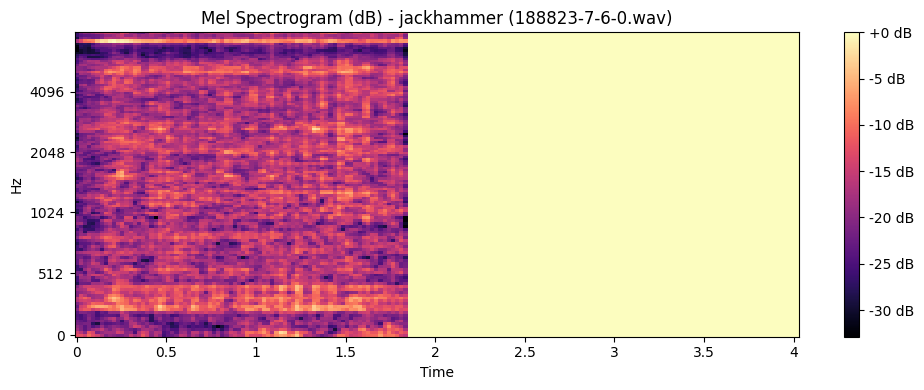

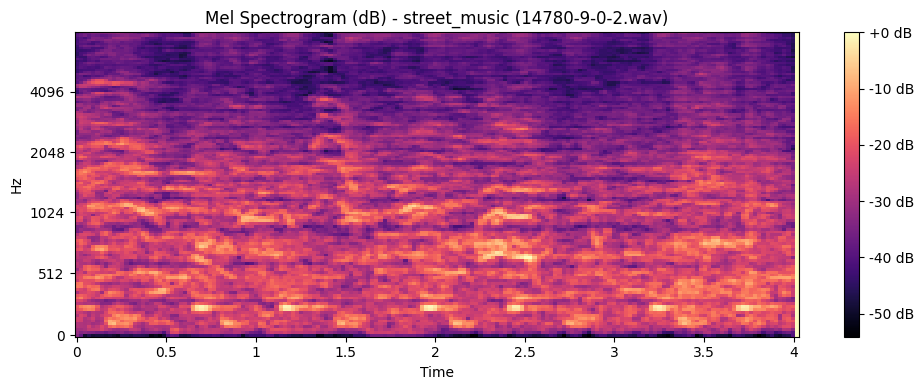

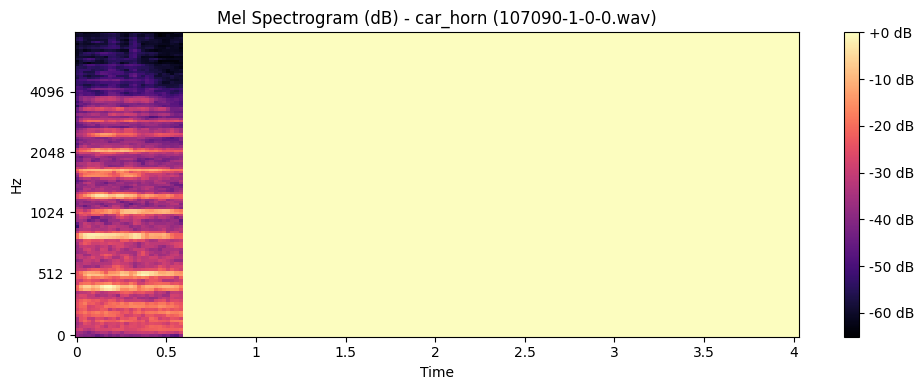


--- Finished Mel Spectrogram Plotting ---

Notebook execution complete.


In [59]:
print("\n--- Plotting Some Mel Spectrograms for Verification ---")

# Select a few files to display
# You can use the first few from the loaded metadata_df_global or specify manually
num_spectrograms_to_plot = 3
if len(metadata_df_global) >= num_spectrograms_to_plot:
    samples_to_plot = metadata_df_global.sample(n=num_spectrograms_to_plot, random_state=123) # Use random_state for reproducibility
    
    for index, row in samples_to_plot.iterrows():
        file_path_to_plot = os.path.join(fulldatasetpath, f"fold{row['fold']}", row['slice_file_name'])
        class_label_for_plot = row['class']
        
        if os.path.exists(file_path_to_plot):
            plot_mel_spectrogram(file_path_to_plot, class_label=class_label_for_plot)
        else:
            print(f"File not found for plotting: {file_path_to_plot}")
else:
    print("Not enough data in metadata to plot spectrograms.")
    
print("\n--- Finished Mel Spectrogram Plotting ---")
print("\nNotebook execution complete.")